Hunter Bennett | Glass Lab | Brain Aging Project | 27 Feb 2021

Goal of this analysis is to compare promoter acetylation in 4 month microglia to gene expression in 4 month microglia as a way of justifying the use of promoter acetylation as a proxy for gene expression.

In [2]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
import itertools
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat
from homer_preprocessing import read_annotated_peaks

### Set working paths

In [3]:
dataDirectory = '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/'
inputDirectory = '/data/mm10/Brain_MPSIIIA/ChIP/input/'
workingDirectory = '/home/h1bennet/brain_aging/results/04_Young_Cell_H3K27Ac/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

Read in color scheme dictionary

In [4]:
hex_dict={}
rgb_dict={}
for line in open('/home/h1bennet/brain_aging/data/brain_aging_color_table.txt','r'):
    split = line.strip().replace('\ufeff','').split('\t')
    # split2 = split[1]
    hex_dict[split[0]] = split[1]
    rgb_dict[split[0]] = split[2]    

# Read in annotated promoters

Mouse promoters

In [46]:
# import annotation file
df, mat = read_annotated_peaks('./merged_peaks/ann_norm_promoters.txt')

# # try with dropped sample
dropsamp = ['XXX']
drop_files = mat.columns[mat.columns.str.contains('|'.join(dropsamp))]
df = df.drop(drop_files, axis=1)

# pull gene name for merging - capitalize to match human gene names
df = df.set_index('Gene Name')
df.index = df.index.str.upper()

# extract just tag counts
mat = df.loc[:, df.columns.str.contains('Brain_MPSIIIA')]

In [52]:
groups = ['olig_4month', 'neun_4month', 'pu1_4month', 'sox9_4month']
columns = [[0,1,2],
           [3,4,5,6,7],
           [8,9,10],
           [11,12]]

avg_tss = {}

for group, col in zip(groups, columns):
    avg_tss[group] = mat.iloc[:, col].mean(1)
    
avg_tss_df = pd.DataFrame(avg_tss)

Human promoters

In [61]:
# import annotation file
hum_df, hum_mat = read_annotated_peaks(
    '/gpfs/data01/glasslab/home/h1bennet/brain_aging/data/annotated_peaks_tss_with_pooled_tagdirs_H3K27ac_norm.txt')

# # try with dropped sample
dropsamp = ['XXX']
drop_files = hum_mat.columns[hum_mat.columns.str.contains('|'.join(dropsamp))]

hum_df = hum_df.drop(drop_files, axis=1)
hum_mat = hum_mat.drop(drop_files, axis=1)

# pull gene name for merging - capitalize to match human gene names
hum_df = hum_df.set_index('Gene Name')

# extract matrix
hum_mat = hum_df.loc[:, hum_df.columns.str.contains('H3K27ac')]

In [97]:
hum_mat.columns

Index(['/data/hg19/Nuclei/merged_tag_dir/human_LHX2nuclei_H3K27ac_epilepsy_pooled_hg19/',
       '/data/hg19/Nuclei/merged_tag_dir/human_NEUNnuclei_H3K27ac_epilepsy_pooled_hg19/',
       '/data/hg19/Nuclei/merged_tag_dir/human_OLIG2nuclei_H3K27ac_epilepsy_pooled_hg19/',
       '/data/hg19/Nuclei/merged_tag_dir/human_PU1nuclei_H3K27ac_epilepsy_pooled_hg19/'],
      dtype='object')

# Compare tss values for genes across species
____
Since we are comparing analagous genes we can't match based on refseq ID, instead we will need to match based on gene name, and thus collapse expression down to one per gene, pick based on highest level of acetylation.

In [98]:
i = '/data/hg19/Nuclei/merged_tag_dir/human_NEUNnuclei_H3K27ac_epilepsy_pooled_hg19/'
j = 'neun_4month'

In [99]:
# sort values highest first, this way the first entry of any gene
# will come first in the list
tst = avg_tss_df[j].sort_values(ascending=False)
# filter duplicates, keeping the first instance which is the highest expressed
tst = tst[~tst.index.duplicated()]

In [100]:
# sort values highest first, this way the first entry of any gene
# will come first in the list
tst_hum = hum_mat[i].sort_values(ascending=False)
# filter duplicates, keeping the first instance which is the highest expressed
tst_hum = tst_hum[~tst_hum.index.duplicated()]

In [101]:
tst_merge = pd.merge(tst, tst_hum, left_index=True, right_index=True)

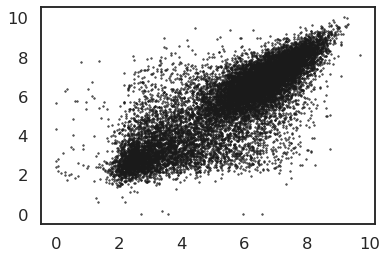

In [102]:
plt.scatter(
    np.log2(tst_merge[i]+1),
    np.log2(tst_merge[j]+1),
    s=0.5,
    c='k')

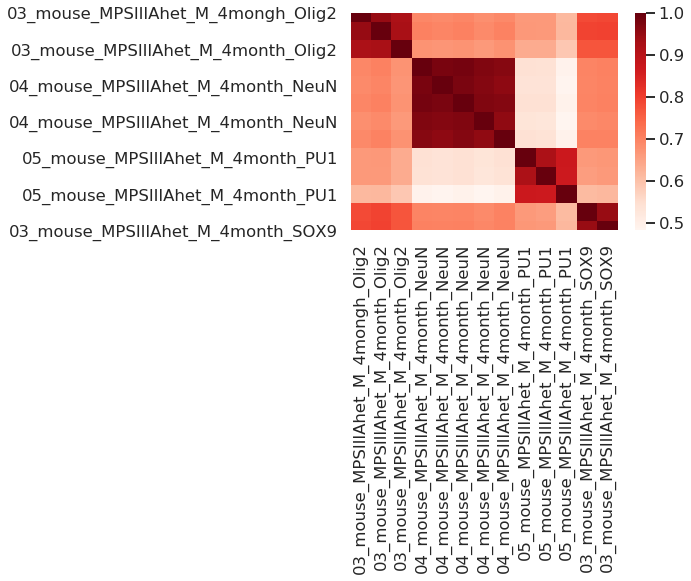

In [12]:
tmp_mat = mat
tmp_mat.columns = tmp_mat.columns.str.split('/').str[-1].str.split('_ChIP_').str[0]

sns.heatmap(tmp_mat.corr('spearman'),
            cmap='Reds')